# library import

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#model 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# hyper pram tuning library
from sklearn.model_selection import GridSearchCV

#time
import time

# data import

In [48]:
# data path set

data_dir = "./data"
train_data_path = join(data_dir, 'sales_train.csv') #train data
test_data_path = join(data_dir, 'test.csv') #test data

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

categories_data_path = join(data_dir, 'item_categories.csv') #카테고리: 네임, 카테고리 아이디
items_path = join(data_dir, 'items.csv') # 아이템: 이름, id,  카테고리id
shops_path = join(data_dir, 'shops.csv') # 매장명: 매장명, id

# data import
origin_train = pd.read_csv(train_data_path)
origin_test = pd.read_csv(test_data_path)

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

# 
categories= pd.read_csv(categories_data_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shops_path)



# data 파악

In [52]:
origin_train.shape

(2935849, 6)

In [ ]:
origin_train

In [54]:
origin_train.head(30)
# 월 정보 index column

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [31]:
origin_test.head() # test data

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [32]:
categories.head() # 카테고리 파일

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [33]:
shops.head() # 매장 파일

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [34]:
items.head() # 아이템 제품 파일

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [35]:
## 매장별 월별 데이터

# data preprocessing

In [ ]:
## Y data, 

## 결측 데이터 숙청

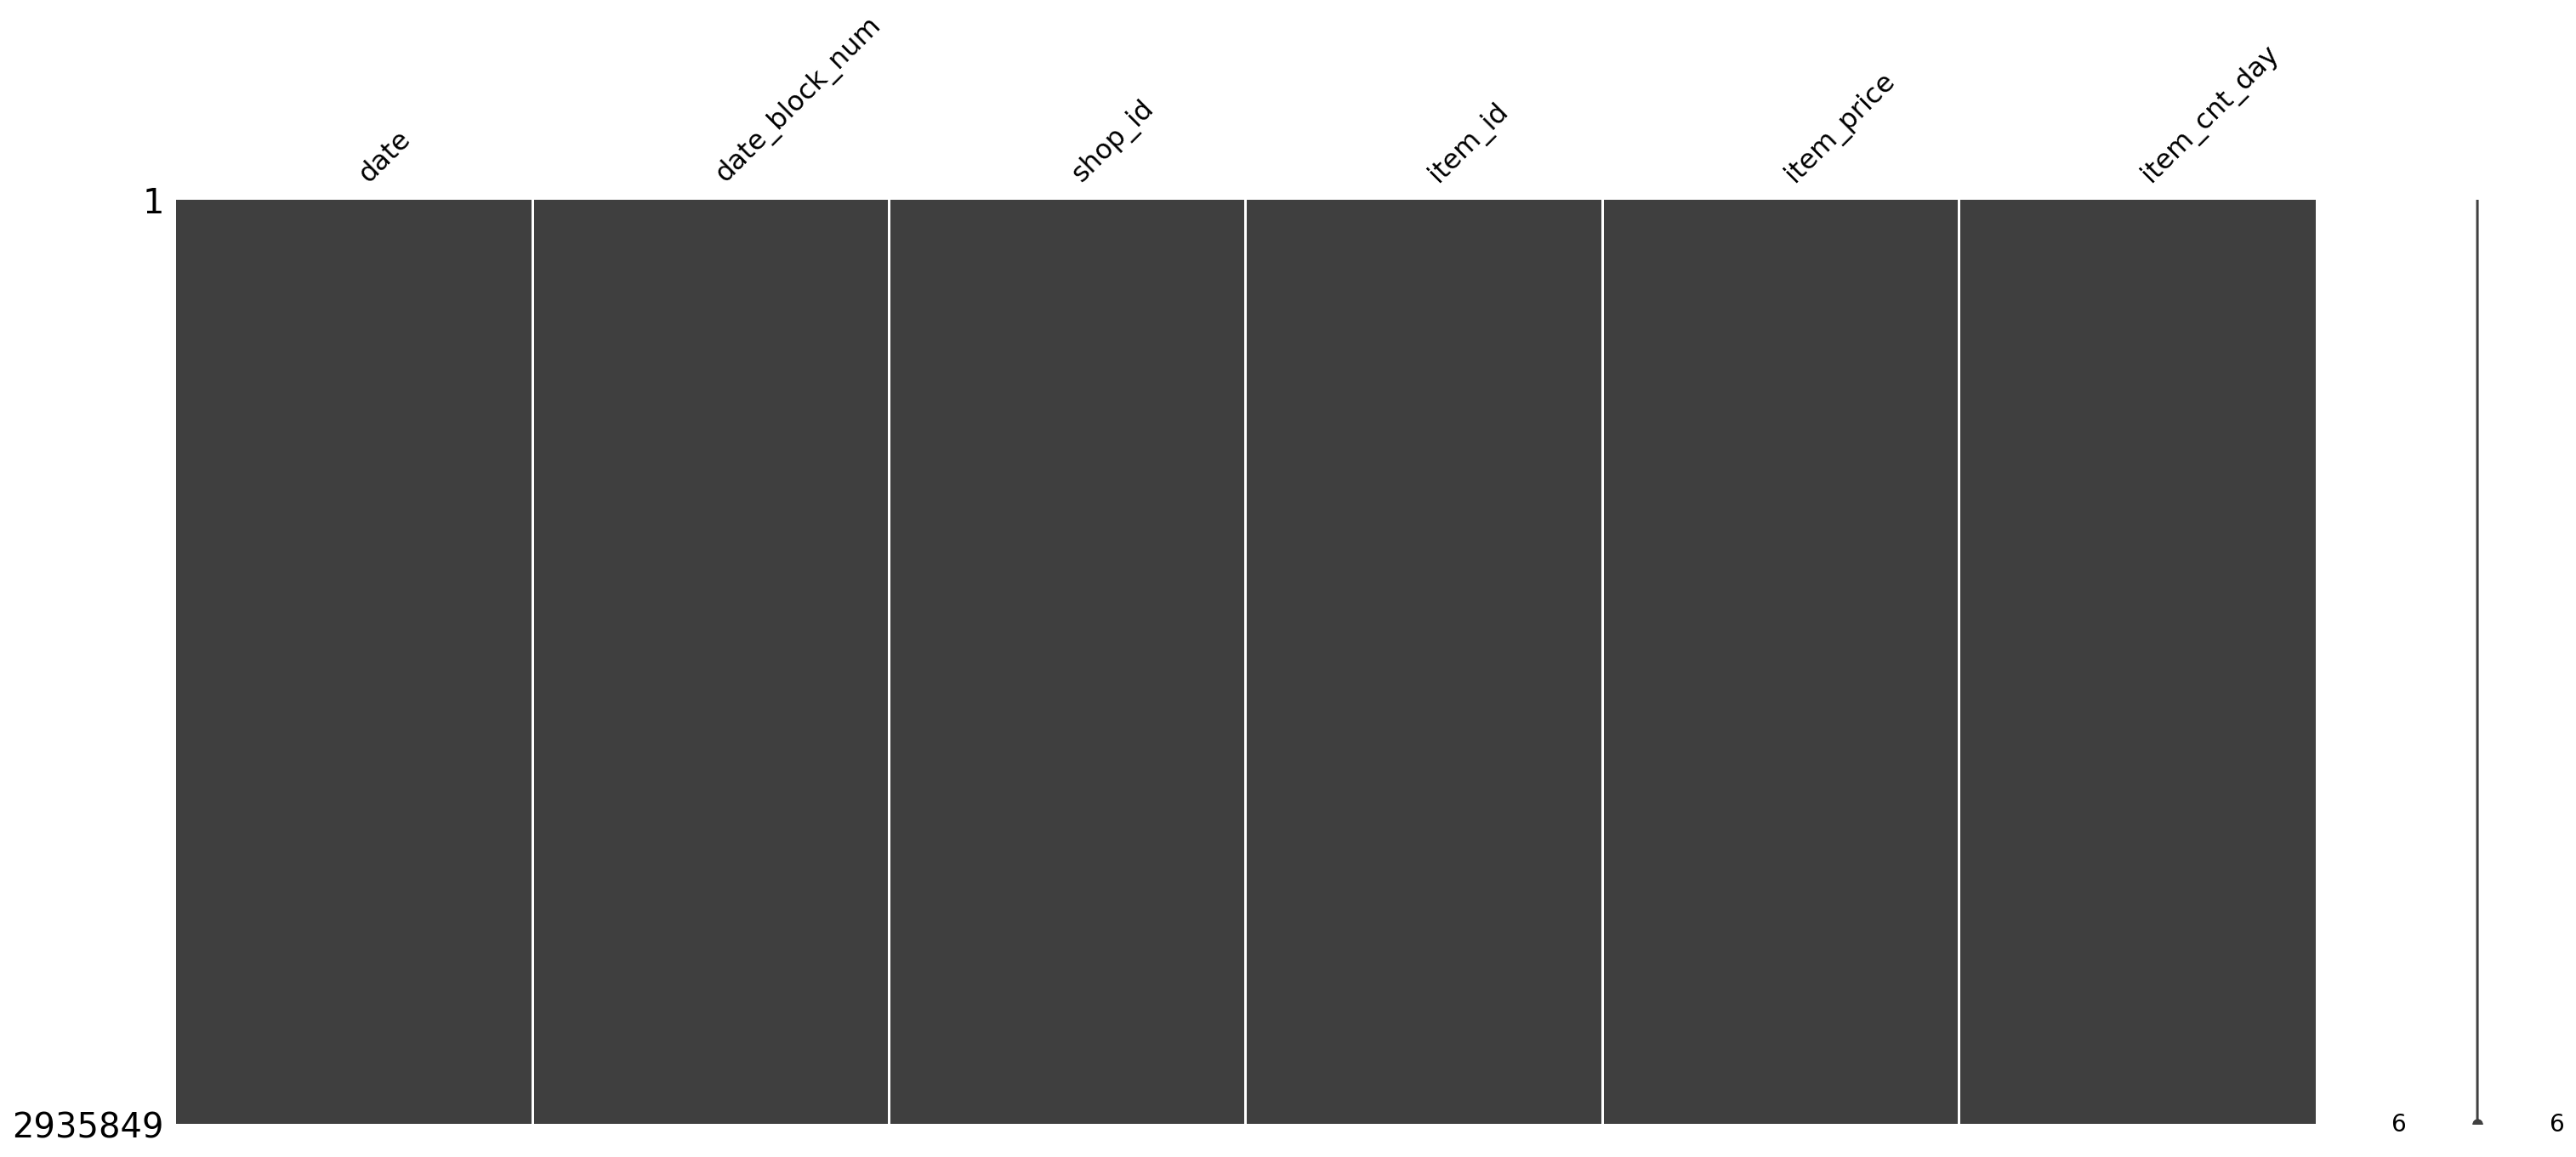

In [53]:
# 결측데이터 graph
msno.matrix(train)

In [38]:
print("------train data 결측------")
for c in origin_train.columns:
    print('{} : {}'.format(c, len(origin_train.loc[pd.isnull(origin_train[c]), c].values)))
print("\n------test data 결측-------")
for c in origin_test.columns:
    print('{} : {}'.format(c, len(origin_test.loc[pd.isnull(origin_test[c]), c].values)))

------train data 결측------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0

------test data 결측-------
ID : 0
shop_id : 0
item_id : 0


In [ ]:
#결측 데이더 없~~넹...

## 중복 데이터 숙청

In [39]:
origin_train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [47]:
#trade[(trade['기간']=='2020년 03월')&(trade['국가명']=='중국')]
origin_train[(origin_train['date'] == '05.01.2013')&orgin_train['shop_id']='54']

SyntaxError: invalid syntax (<ipython-input-47-7bc2c456763a>, line 2)

## 불필요 데이터 숙청
- date 의 날짜 제외

## 월별 데이터로 그룹
- 날짜 삭제
- 매장별 월별 그룹핑

## y값 처리
- train 에서 y 값 도려내기
- y 값 분포 조정

In [ ]:
## 

# model 

In [55]:
# reference

# test

In [44]:
origin_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [ ]:
su